#### Necessary libraries, the usual suspects...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

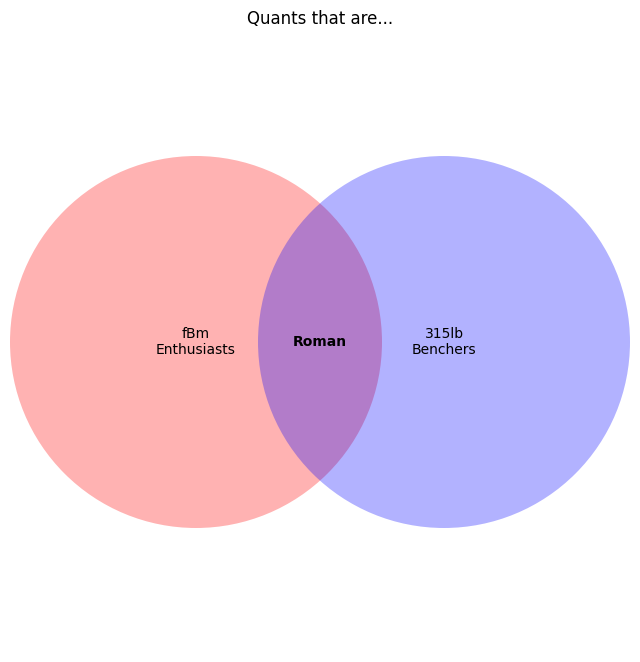

In [2]:
# Create a Venn diagram
plt.figure(figsize=(8, 16))

# Create two circles
circle1 = plt.Circle((0.3, 0.5), 0.3, alpha=0.3, fc='red', label='People that love generating\nfractional Brownian motion')
circle2 = plt.Circle((0.7, 0.5), 0.3, alpha=0.3, fc='blue', label='People that can\nbench 315lbs')

# Add circles to plot
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)

# Add text labels
plt.text(0.3, 0.5, 'fBm\nEnthusiasts', ha='center', va='center')
plt.text(0.7, 0.5, '315lb\nBenchers', ha='center', va='center')
plt.text(0.5, 0.5, 'Roman', ha='center', va='center', fontweight='bold')

# Set plot limits and remove axes
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.axis('off')

plt.title('Quants that are...')
plt.show()


# Fractional Brownian Motion in Financial Modeling

Fractional Brownian motion (fBm) represents a fascinating generalization of standard Brownian motion, characterized by its Hurst parameter $H \in (0,1)$. Unlike classical Brownian motion $(H=\frac{1}{2})$, fBm exhibits long-range dependence when $H > \frac{1}{2}$ and anti-persistence when $H < \frac{1}{2}$.

Let $\{B_H(t)\}_{t \geq 0}$ denote fractional Brownian motion with Hurst parameter $H$. The process is characterized by:
 
 1. **Fractional Gaussian Noise (fGn)**: The increments process $\{X_k = B_H(k+1) - B_H(k)\}_{k \geq 0}$ is called fractional Gaussian noise, with:
    - Stationary increments
    - Covariance function: $\gamma(k) = \frac{1}{2}(|k+1|^{2H} - 2|k|^{2H} + |k-1|^{2H})$
 
 2. **Fractional Brownian Motion**: The process $B_H(t)$ is obtained by:
    - Starting at zero: $B_H(0) = 0$
    - Accumulating fGn: $B_H(t) = \sum_{k=0}^{\lfloor t \rfloor} X_k + (t-\lfloor t \rfloor)X_{\lfloor t \rfloor}$
 
 When $H = \frac{1}{2}$, we recover standard Brownian motion because:
 - The increments become independent (white noise)
 - The covariance reduces to $\gamma(k) = \delta_{k,0}$ (Kronecker delta)
 - The process exhibits the familiar $\sqrt{t}$ scaling of variance


## Financial Applications & Challenges

In financial modeling, fBm has garnered significant attention due to its ability to capture:
- Long-memory effects in asset returns
- Volatility clustering
- Market inefficiencies

However, its non-Markovian nature presents substantial challenges:

1. **Option Pricing**: The lack of the Markov property means classical no-arbitrage pricing frameworks (like Black-Scholes) break down, requiring:
   - Modified stochastic calculus (Wick-Itô integration)
   - Alternative pricing approaches (e.g., rough volatility models)

2. **Volatility Surface Modeling**: The presence of memory effects leads to:
   - Non-local dependencies in implied volatility surfaces
   - Complex calibration procedures for $H \neq \frac{1}{2}$

3. **Risk Management**: Traditional risk measures need modification to account for:
   - Path-dependence
   - Non-semimartingale behavior when $H \neq \frac{1}{2}$

The mathematical richness of fBm continues to inspire new approaches in quantitative finance, particularly in the emerging field of rough volatility modeling where $H < \frac{1}{2}$.


# Davies-Harte for simulating fractional Brownian motion (fBm)

### Inputs:
- $H \in (0,1)$: Hurst Parameter
- $T$: total time (usually normalized to 1)
- N: time steps (fBm will have N+1 points)

### Steps:

#### 1.) Generate a time grid
$t_k = \frac{kT}{N}$

**In Python:**
```python
# Time grid (N+1 points)
t = np.linspace(0, T, N+1)
```

#### 2.) Define the autocovariance of fractional Gaussian noise (fGn)
$\gamma(k) = \frac{1}{2}(|k+1|^{2H} - 2|k|^{2H} + |k-1|^{2H})$

**In Python:**
```python
# Autocovariance function
gamma = lambda k: 0.5 * (abs(k + 1)**(2 * H) - 2 * abs(k)**(2 * H) + abs(k - 1)**(2 * H))
```

#### 3.) Form the circulant vector of autocovariances
$c = [\gamma(0), \gamma(1), \dots, \gamma(N-1), \gamma(N), \gamma(N-1), \dots, \gamma(1)]$

Note: $\gamma(k) = 0 \text{ for } k > N$, that is the autocovariance outside the scope is zero

**In Python:**
```python
# Circulant vector
c = np.concatenate([np.array([gamma(k) for k in range(N+1)]), np.array([gamma(k) for k in range(N-1, 0, -1)])])
```

#### 4.) Compute the eigenvalues using FFT

$\lambda = Re(FFT(c))$, we are only interested in real positive eigenvalues (it is a covariance embedding after all)

Note: we must consider how FFT/IFFT scales by default in Python! in Python numpy FFT computes the unnormalized discrete fourier transform.

**In Python:**
```python
# Real eigenvalues
L = np.fft.fft(c).real
if not np.allclose(np.fft.fft(c).imag, 0, atol=1e-10):
    raise ValueError("FFT has significant imaginary components, check input vector.")

if np.any(L < 0):
    raise ValueError("Negative eigenvalues encountered — invalid circulant embedding.")
```

#### 5.) Generate a complex Gaussian vector

Note: Vector of eigenvalues $\lambda$ will be larger than $N$ as the length will be $2N$ we truncate the vectore to N as needed

$Z \in \mathbb{C}^{2N}$

For start and end points:
$Z_0 \sim N(0, \lambda_0$)

$Z_N \sim N(0, \lambda_N)$

For intermediate points:

For $1 \leq k < N$:
$Z_k = \sqrt{\frac{\lambda_k}{2}}(X_k + iY_k)$

$X_k, Y_k \sim N(0, 1)$ are N independent draws from a standard normal distribution

Define $Z_{2N - k} = \bar{Z_k}$ (the conjugate)

In Python:
```python
# FFT Length
M = 2 * N

# Generate standard normals
Z = np.zeros(M, dtype=np.complex128)

# Real parts
Z[0] = np.sqrt(L[0]) * np.random.normal()
Z[N] = np.sqrt(L[N]) * np.random.normal()

# For 1 ≤ k < N
X = np.random.normal(0, 1, N - 1)
Y = np.random.normal(0, 1, N - 1)

for k in range(1, N):
    Z[k] = np.sqrt(L[k] / 2) * (X[k-1] + 1j * Y[k-1])
    Z[M - k] = np.conj(Z[k])
```

#### Step 6.) Inverse FFT to get fractional Gaussian noise

$fGn = Re(IFFT(Z))$

Note: in Python IFFT introduces a factor of 1 / M (the total path length of 2N) which will mess up the scaling and give incorrect variance of fractional Gaussian noise

We thus will scale by $\sqrt{M}$.

Moreover, the scheme assumes unit variance in the inverse FFT so we will also scale by $(\frac{T}{N})^{H}$ to have correct time-scaling

In other words (or math): $Var[B_H(t_k) - B_H(t_{k-1})] = (\frac{T}{N})^{2H}$, remember this is a variance term of sorts so to acheive this we can scale by $\sqrt{(\frac{T}{N})^{2H}} = (\frac{T}{N})^{H}$

**In Python:**
```python
# Inverse FFT to recover fGn
fGn = np.fft.ifft(Z).real[:N] * (T / N) ** H * np.sqrt(M)
```

#### Step 7.) Obtain fractional Brownian motion

$B_H(t_k) = \sum_{j=0}^k fGn_j, k=0, 1, \dots, N$
**In Python:**
```python
# Cumsum for fBm
fbm = np.concatenate([np.array([0]), np.cumsum(fGn)])
```

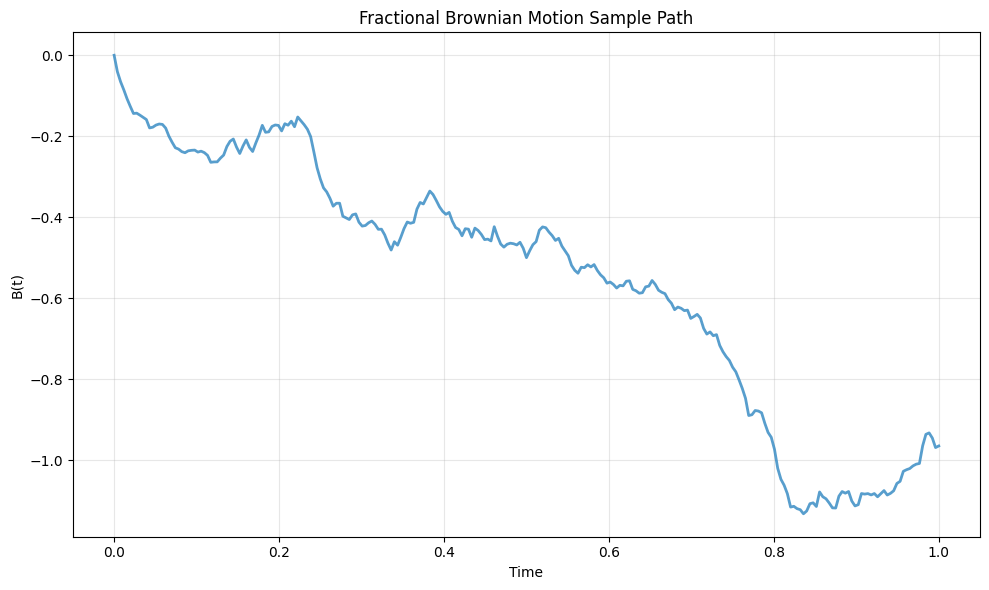

In [3]:
def davies_hart_fbm(N, H, T=1):
    # Time grid
    t = np.linspace(0, T, N+1)

    # Autocovariance function
    gamma = lambda k: 0.5 * (abs(k + 1)**(2 * H) - 2 * abs(k)**(2 * H) + abs(k - 1)**(2 * H))

    # Circulant vector
    c = np.concatenate([np.array([gamma(k) for k in range(N+1)]), np.array([gamma(k) for k in range(N-1, 0, -1)])])

    # Real eigenvalues
    L = np.fft.fft(c).real
    if not np.allclose(np.fft.fft(c).imag, 0, atol=1e-10):
        raise ValueError("FFT has significant imaginary components, check input vector.")

    if np.any(L < 0):
        raise ValueError("Negative eigenvalues encountered — invalid circulant embedding.")
    
    # FFT Length
    M = 2 * N

    # Generate standard normals
    Z = np.zeros(M, dtype=np.complex128)

    # Real parts
    Z[0] = np.sqrt(L[0]) * np.random.normal()
    Z[N] = np.sqrt(L[N]) * np.random.normal()

    # For 1 ≤ k < N
    X = np.random.normal(0, 1, N - 1)
    Y = np.random.normal(0, 1, N - 1)

    for k in range(1, N):
        Z[k] = np.sqrt(L[k] / 2) * (X[k-1] + 1j * Y[k-1])
        Z[M - k] = np.conj(Z[k])

    # Inverse FFT to recover fGn
    fGn = np.fft.ifft(Z).real[:N] * np.sqrt(M) * (T / N) ** H

    # Cumsum for fBm
    fbm = np.concatenate([np.array([0]), np.cumsum(fGn)])

    # Return the time grid, fractional Gaussian noise, and fractional Brownian motion
    return t, fGn, fbm

fbm = davies_hart_fbm(256, .75, 1)
plt.figure(figsize=(10, 6))
plt.plot(fbm[0], fbm[2], linewidth=2, color='#2E86C1', alpha=0.8)
plt.title('Fractional Brownian Motion Sample Path', fontsize=12)
plt.xlabel('Time', fontsize=10)
plt.ylabel('B(t)', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

### A Rough check of fractional variance covariance structure

In [7]:
T = 1.0
N = 256
H = 0.75
M = 10000

# davies_hart_fbm doit retourner (t, fgn, fbm) avec fgn shape (N,) et fbm shape (N+1,)
fgn_paths = np.stack([davies_hart_fbm(N, H, T=T)[1] for _ in range(M)])   # (M, N)
fbm_paths = np.stack([davies_hart_fbm(N, H, T=T)[2] for _ in range(M)])   # (M, N+1)

# --- Var(fGn) correcte: variance inter-chemins, pas dans le temps ---
theo_var_fgn = (T/N)**(2*H)
# soit au pas 1:
emp_var_fgn_1 = np.var(fgn_paths[:, 0], ddof=1)
# soit moyenne sur tous les pas (même loi marginale):
emp_var_fgn = np.mean(np.var(fgn_paths, axis=0, ddof=1))
print(f"Var(fGn) theo={(theo_var_fgn):.6g}  emp@k=1={emp_var_fgn_1:.6g}  emp(mean over k)={emp_var_fgn:.6g}")

# --- Var(B_H(T)) ---
theo_var_fbmT = T**(2*H)
emp_var_fbmT = np.var(fbm_paths[:, -1], ddof=1)
print(f"Var(B(T)) theo={theo_var_fbmT:.6g}  emp={emp_var_fbmT:.6g}")

# --- (optionnel) autocovariance du fGn et check de la forme théorique ---
def gamma(h, H):
    h = np.abs(h)
    return 0.5*(np.abs(h+1)**(2*H) - 2*np.abs(h)**(2*H) + np.abs(h-1)**(2*H))

max_lag = 10
theo_cov = (T/N)**(2*H) * np.array([gamma(h, H) for h in range(max_lag+1)])
# estimateur: moyenne sur chemins puis moyenne temporelle des produits centrés
fgn_centered = fgn_paths - fgn_paths.mean(axis=0, keepdims=True)  # centre par pas
emp_cov = []
for h in range(max_lag+1):
    prod = fgn_centered[:, :-h or None] * fgn_centered[:, h:]
    emp_cov.append(prod.mean())
emp_cov = np.array(emp_cov)
print("max rel err autocov (h<=10):", np.max(np.abs(emp_cov - theo_cov)/np.maximum(1e-12, np.abs(theo_cov))))


Var(fGn) theo=0.000244141  emp@k=1=0.000244596  emp(mean over k)=0.00024421
Var(B(T)) theo=1  emp=0.973451
max rel err autocov (h<=10): 0.01528960086353205


### fbm: Empirical Variance Covariance Structure relative to Theoretical Variance Covariance Structure 

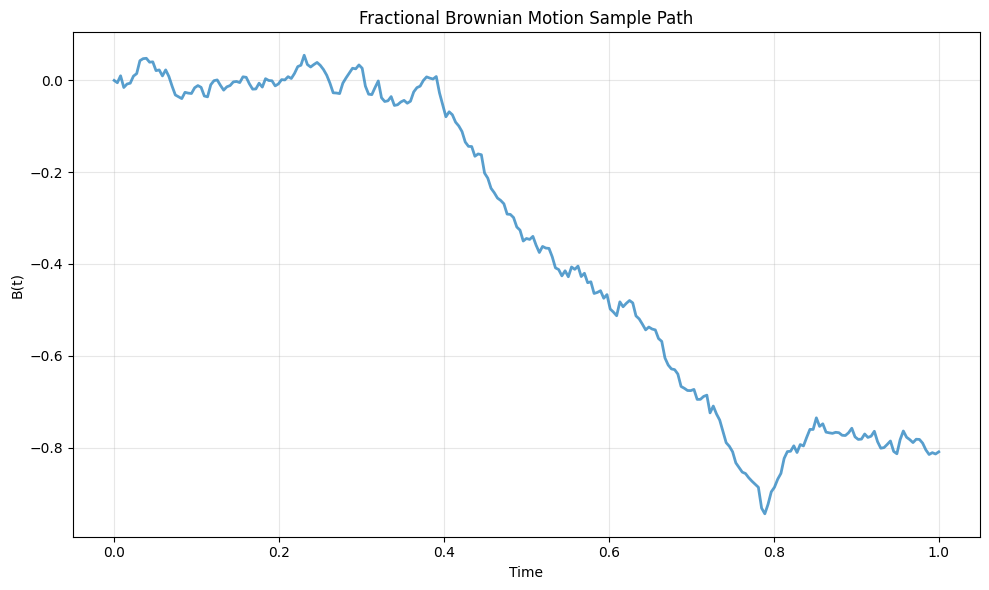

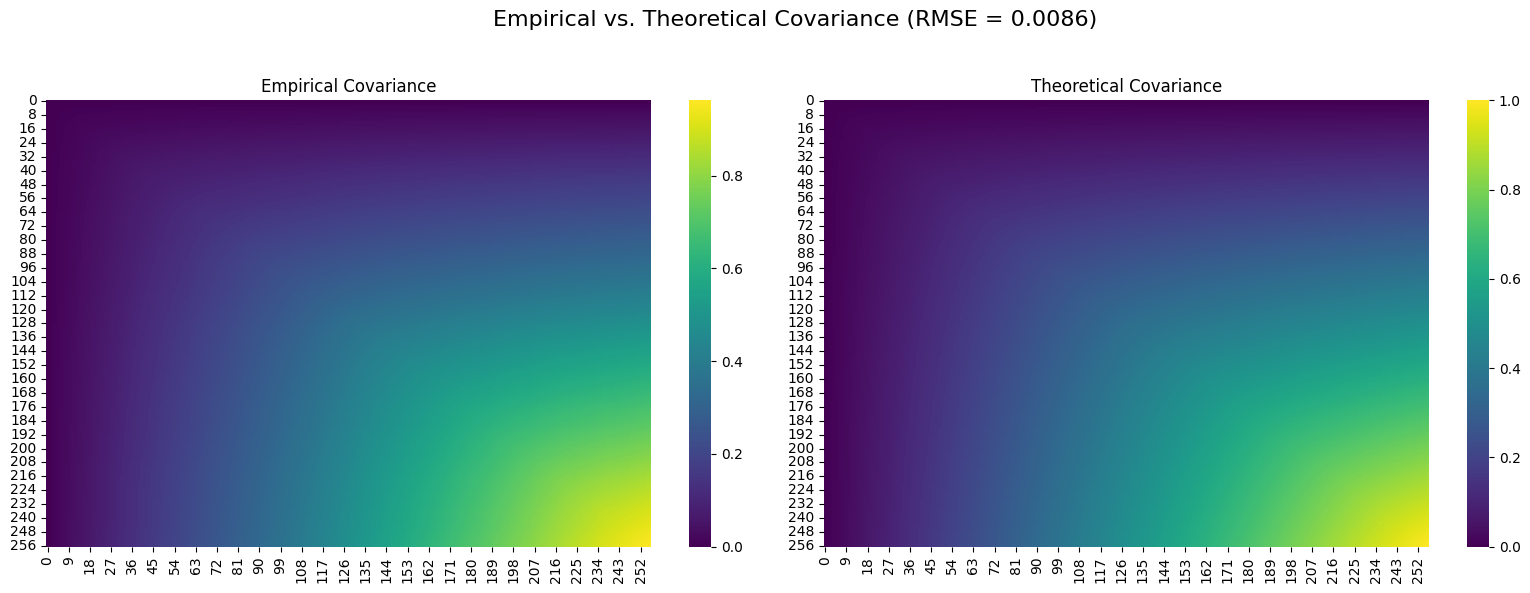

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Davies-Harte fBm implementation
def davies_hart_fbm(N, H, T=1):
    t = np.linspace(0, T, N+1)

    gamma = lambda k: 0.5 * (abs(k + 1)**(2 * H) - 2 * abs(k)**(2 * H) + abs(k - 1)**(2 * H))

    c = np.concatenate([np.array([gamma(k) for k in range(N+1)]), np.array([gamma(k) for k in range(N-1, 0, -1)])])
    L = np.fft.fft(c).real

    if not np.allclose(np.fft.fft(c).imag, 0, atol=1e-10):
        raise ValueError("FFT has significant imaginary components, check input vector.")

    if np.any(L < 0):
        raise ValueError("Negative eigenvalues encountered — invalid circulant embedding.")

    M = 2 * N
    Z = np.zeros(M, dtype=np.complex128)
    Z[0] = np.sqrt(L[0]) * np.random.normal()
    Z[N] = np.sqrt(L[N]) * np.random.normal()

    X = np.random.normal(0, 1, N - 1)
    Y = np.random.normal(0, 1, N - 1)
    for k in range(1, N):
        Z[k] = np.sqrt(L[k] / 2) * (X[k-1] + 1j * Y[k-1])
        Z[M - k] = np.conj(Z[k])

    fGn = np.fft.ifft(Z).real[:N] * (T / N) ** H * np.sqrt(M)
    fbm = np.concatenate([np.array([0]), np.cumsum(fGn)])
    return t, fGn, fbm

# Generate multiple paths to estimate empirical covariance
N = 256
H = 0.75
T = 1
n_paths = 1000

fbm_samples = np.zeros((n_paths, N+1))
for i in range(n_paths):
    _, _, fbm_path = davies_hart_fbm(N, H, T)
    fbm_samples[i, :] = fbm_path

# Empirical covariance
empirical_cov = np.cov(fbm_samples.T)

# Theoretical covariance of fBm
t = np.linspace(0, T, N+1)
theoretical_cov = np.zeros((N+1, N+1))
for i in range(N+1):
    for j in range(N+1):
        theoretical_cov[i, j] = 0.5 * (t[i]**(2*H) + t[j]**(2*H) - abs(t[i] - t[j])**(2*H))

# RMSE between empirical and theoretical
rmse = np.sqrt(np.mean((empirical_cov - theoretical_cov)**2))

fbm = davies_hart_fbm(N, H, T)
plt.figure(figsize=(10, 6))
plt.plot(fbm[0], fbm[2], linewidth=2, color='#2E86C1', alpha=0.8)
plt.title('Fractional Brownian Motion Sample Path', fontsize=12)
plt.xlabel('Time', fontsize=10)
plt.ylabel('B(t)', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Plot heatmaps
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(empirical_cov, cmap="viridis")
plt.title("Empirical Covariance")

plt.subplot(1, 2, 2)
sns.heatmap(theoretical_cov, cmap="viridis")
plt.title("Theoretical Covariance")

plt.suptitle(f"Empirical vs. Theoretical Covariance (RMSE = {rmse:.4f})", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### fGn Variance: Theoretical RMSE improvement in $N$ relative to theoretical improvement in $N$

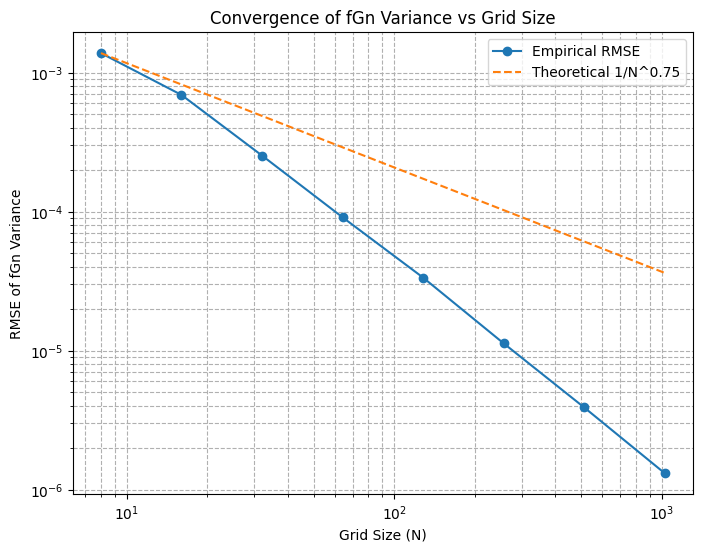

In [399]:
# Test different grid sizes (N values) for fGn variance convergence
grid_sizes = [8, 16, 32, 64, 128, 256, 512, 1024]
rmses = []
M = 1000  # Number of sample paths for each N

for N_test in grid_sizes:
    fgn_samples = np.zeros((M, N_test))
    for i in range(M):
        _, fgn_path, _ = davies_hart_fbm(N_test, H, T)
        fgn_samples[i, :] = fgn_path
    
    # Calculate empirical variance at each time point
    empirical_var = np.var(fgn_samples, axis=0)
    
    # Theoretical variance of fGn
    t = np.linspace(0, T, N_test)
    dt = T/N_test
    theoretical_var = dt**(2*H) * np.ones(N_test)
    
    # RMSE between empirical and theoretical variance
    rmse = np.sqrt(np.mean((empirical_var - theoretical_var)**2))
    rmses.append(rmse)

# Theoretical reference: RMSE ~ 1/N^H
theoretical_rmse = [rmses[0] * (grid_sizes[0]/n)**H for n in grid_sizes]

# Prepare dataframe for plotting
df = pd.DataFrame({
    "Grid Size (N)": grid_sizes,
    "Empirical RMSE": rmses,
    "Theoretical RMSE ~ 1/N^H": theoretical_rmse
})

plt.figure(figsize=(8, 6))
plt.loglog(grid_sizes, rmses, 'o-', label="Empirical RMSE")
plt.loglog(grid_sizes, theoretical_rmse, '--', label=f"Theoretical 1/N^{H}")
plt.xlabel("Grid Size (N)")
plt.ylabel("RMSE of fGn Variance")
plt.title("Convergence of fGn Variance vs Grid Size")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

### fBm Variance: Empirical RMSE improvement in $M$ relative to theoretical improvement in $M$ 

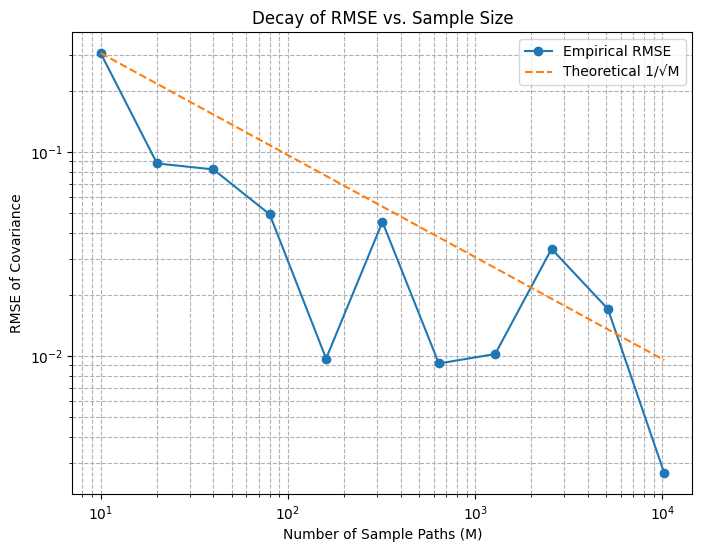

In [400]:
# Test different sample sizes (M values) for RMSE decay
sample_sizes = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240]
rmses = []

for M in sample_sizes:
    fbm_samples = np.zeros((M, N+1))
    for i in range(M):
        _, _, fbm_path = davies_hart_fbm(N, H, T)
        fbm_samples[i, :] = fbm_path

    empirical_cov = np.cov(fbm_samples.T)
    rmse = np.sqrt(np.mean((empirical_cov - theoretical_cov)**2))
    rmses.append(rmse)

# Theoretical reference: RMSE ~ 1/sqrt(M)
theoretical_rmse = [rmses[0] * np.sqrt(sample_sizes[0] / m) for m in sample_sizes]

# Prepare dataframe for plotting
df = pd.DataFrame({
    "Sample Size (M)": sample_sizes,
    "Empirical RMSE": rmses,
    "Theoretical RMSE ~ 1/√M": theoretical_rmse
})

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.loglog(sample_sizes, rmses, 'o-', label="Empirical RMSE")
plt.loglog(sample_sizes, theoretical_rmse, '--', label="Theoretical 1/√M")
plt.xlabel("Number of Sample Paths (M)")
plt.ylabel("RMSE of Covariance")
plt.title("Decay of RMSE vs. Sample Size")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()